Нужна выборка для классификации. Для этого используем синтетическую выборку - точки на параболе. Нарисуем параболу и сгенерируем точки на ней.

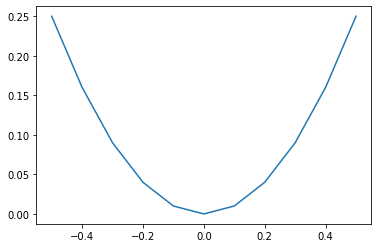

In [1]:
# The following line makes matplotlib compatible with Jupyter
%matplotlib inline

from matplotlib import pyplot as plt
import numpy as np

def calculate(x):
    return x * x

x = np.asarray(list(range(-10, 11, 2)))/20
y = calculate(x)

plt.plot(x, y)
plt.show()

In [2]:
import tensorflow as tf
print(tf.__version__)
tf.compat.v1.disable_eager_execution()

2.0.0-beta1


У нас есть функция, а теперь нам нужно сделать случайные точки, лежащие на функции. Это будет наша обучающая выборка.

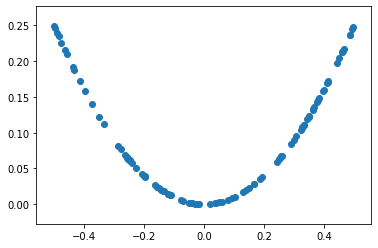

In [3]:
from numpy.random import rand
 
# generate randoms sample from x^2
def generate_real_samples(n=100):
    # generate random inputs in [-0.5, 0.5]
    x = rand(n) - 0.5
    y = calculate(x)
    # stack arrays
    x = x.reshape(n, 1)
    y = y.reshape(n, 1)
    return np.hstack((x, y))
 
data = generate_real_samples()
plt.scatter(data[:, 0], data[:, 1])
plt.show()

Однако нам нужны и неправильные точки, которые не лежат на параболе. Это будет вторым классом объектов для нашего классификатора. Сгенерируем случайные точки в прямоугольнике.

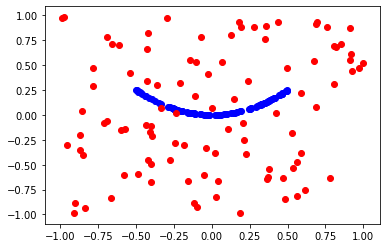

In [4]:
# generate n fake samples
def generate_fake_samples(n=100):
    # generate inputs in [-1, 1]
    x = -1 + rand(n) * 2
    y = -1 + rand(n) * 2
    # stack arrays
    x = x.reshape(n, 1)
    y = y.reshape(n, 1)
    return np.hstack((x, y))

fake = generate_fake_samples()
plt.scatter(data[:, 0], data[:, 1], color='blue')
plt.scatter(fake[:, 0], fake[:, 1], color='red')
plt.show()

Определим модель классификатора. Параметры понятны из аргументов функций. Не будем вдаваться в подробности, но моедль достаточно простая - всего 101 параметр.

In [5]:
# define the discriminator model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
 
# define the standalone discriminator model
def define_discriminator(n_inputs=2):
    model = Sequential()
    model.add(Dense(25, activation='relu', kernel_initializer='he_uniform', input_dim=n_inputs))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
 
# define the discriminator model
model = define_discriminator()
# summarize the model
model.summary()

W1115 20:01:38.751655 14560 deprecation.py:323] From C:\Users\Artem\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_impl.py:182: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 25)                75        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 26        
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


Сгенерируем слитую вместе выборку, указав классы (реальный объект, подделка). Теперь можно обучить модель и посмотреть как быстро она обучилась.

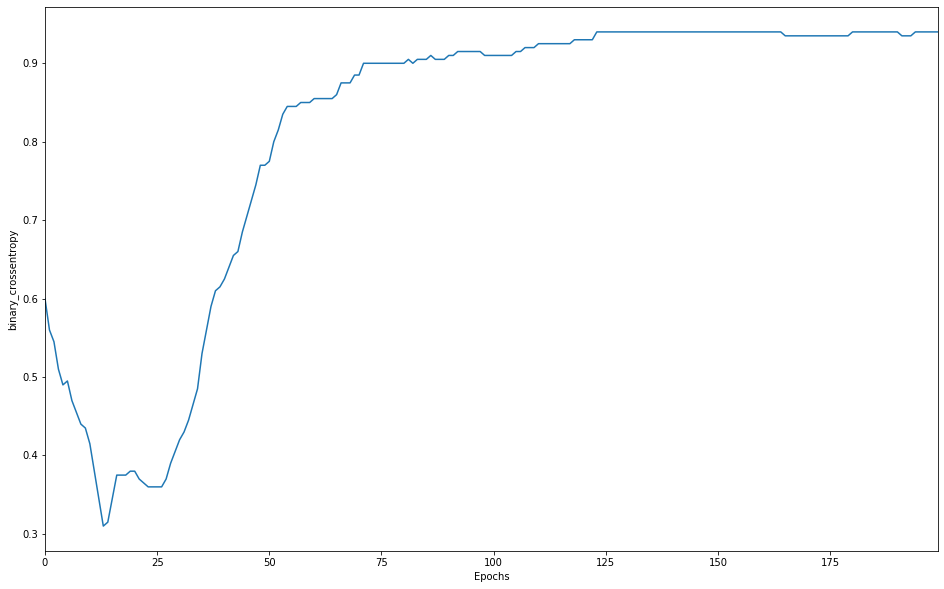

In [6]:
data_y = np.ones(len(data))
fake_y = np.zeros(len(fake))
# print(data.shape)
x_train = np.vstack((data, fake))
# print(x_train.shape)
# print(data_y.shape)
y_train = np.hstack((data_y, fake_y))
# print(y_train.shape)

history = model.fit(x_train, y_train, epochs = 200, verbose = 0)

plt.figure(figsize=(16,10))
plt.xlabel('Epochs')
plt.ylabel("binary_crossentropy")
plt.plot(history.epoch, history.history["accuracy"])
plt.xlim([0,max(history.epoch)])
plt.show()

Теперь у нас есть выборка, есть обученный классификатор и мы можем сделать генератор. Для этого выберем латентное пространство в виде гауссовского распределения с центром в нуле и дисперсией 0. Для примера нарисуем такое распределение для 2D случая.

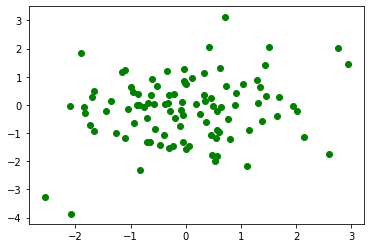

In [7]:
from numpy.random import randn

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n):
    # generate points in the latent space
    x_input = randn(latent_dim * n)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n, latent_dim)
    return x_input

latent_example_2d = generate_latent_points(2, 100)
plt.scatter(latent_example_2d[:, 0], latent_example_2d[:, 1], color = "green")
plt.show()

Теперь определим сеть генератора, которая тоже будет параметризоваться количеством измерений. Выберем пятимерное латентное пространство. Слои примерно такие, как были в классификаторе.

In [8]:
# define the standalone generator model
def define_generator(latent_dim, n_outputs=2):
    model = Sequential()
    model.add(Dense(15, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim))
    model.add(Dense(n_outputs, activation='linear'))
    return model

generator_model = define_generator(5)
# summarize the model
generator_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 15)                90        
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 32        
Total params: 122
Trainable params: 122
Non-trainable params: 0
_________________________________________________________________


Создадим функцию генератора нашего GAN, задача которого будет подавать точки латентного пространства в сеть генератора и выводить x и y, которые в итоге должны научиться попадать на параболу. Обучать его независимо мы не планиурем, поэтому мы его не компилируем.

In [9]:
# use the generator to generate n fake examples
def generate_fake_samples(generator, latent_dim, n):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n)
    # predict outputs
    return generator.predict(x_input)

А теперь возьмём необученную сеть и сгенерируем и нарисуем пары x и y. Удобно сразу сделать функцию визуализации, чтобы там присутствовала и модельная кривая.

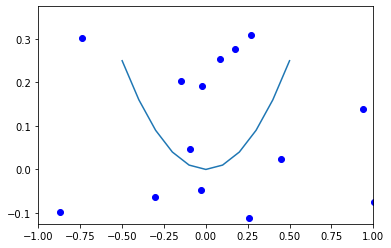

In [10]:
def summarize_performance(generator, latent_dim, n=100, savename = None):
    # prepare fake examples
    x_fake = generate_fake_samples(generator, latent_dim, n)
    # build model dependence
    x = np.asarray(list(range(-10, 11, 2)))/20
    y = calculate(x)
    plt.scatter(x_fake[:, 0], x_fake[:, 1], color='blue')
    x_min = min(x) - 0.5 * (max(x) - min(x))
    x_max = max(x) + 0.5 * (max(x) - min(x))
    y_min = min(y) - 0.5 * (max(y) - min(y))
    y_max = max(y) + 0.5 * (max(y) - min(y))
    plt.ylim([y_min, y_max])
    plt.xlim([x_min, x_max])
    plt.plot(x, y)
    if savename is None:
        plt.show()
    else:
        plt.savefig(savename, format = "png")

summarize_performance(generator_model, 5)

По сути всё сделано, только сеть генератора вообще не тренирована, поэтому она выдала какой-то хаос из точек. Пришло время тренировать генератор. Для этого нужно соединить генератор и классификатор в единую цепь с латентным пространством на входе и бинарной классификацией на выходе. Только перед обучением запомним веса модели, чтобы можно было бы их восстановить.

In [11]:
def define_gan(generator, discriminator):
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(generator)
    # add the discriminator
    model.add(discriminator)
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

gan_model = define_gan(generator_model, model)
# summarize gan model
gan_model.summary()
gan_model.save_weights("output.gan_initial.h5")

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 2)                 122       
_________________________________________________________________
sequential (Sequential)      (None, 1)                 101       
Total params: 223
Trainable params: 122
Non-trainable params: 101
_________________________________________________________________


Теперь нужно выдавать вектора латентного пространства на вход и требовать, чтобы на выходе был класс точек параболы.  Если не получилось, то сеть будет обучаться, чтобы получилось, но обучаться будет только генераторная часть, ведь классификатор зафиксирован в настройках! Именно поэтому выборка включает только один класс. Сделаем для этого функцию обучения и запустим её. Загрузим веса из файла, хотя они и так загружены, но зато этот блок можно перезапускать и каждый раз будет обучаться с нуля.

In [12]:
# train the composite model
def train_gan(gan_model, latent_dim, n_epochs=10000, n_batch=128):
    # manually enumerate epochs
    for i in range(n_epochs):
        # prepare points in latent space as input for the generator
        x_gan = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = np.ones((n_batch, 1))
        # update the generator via the discriminator's error
        gan_model.train_on_batch(x_gan, y_gan)

#gan_model.load_weights("output.gan_initial.h5")
train_gan(gan_model, 5, n_epochs = 5000)

Визуализируем результат. Для этого сгенерируем точки на параболе.

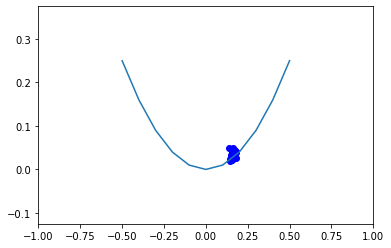

In [13]:
summarize_performance(generator_model, 5)

Точки сгрудились вместе где-то в районе параболы. Чем дальше мы будем обучать генератор, тем больше он будет пытаться выдавать константу. Исправим это тем, что будем дообучать дискриминатор с обучением генератора в соревновательном режиме. Для этого определим соответствующую функцию обучения, которая будет принимать дополнительно модель генератора и дискриминатора, ведь дискриминатор мы собираемся доучивать, а генератор нужен, чтобы генерировать ошибочный класс для обучения дискриминатора. Алгоритм похож на алгоритм train_gan, но в цикле еще нужно сделать обучающую выборку из точек на на параболе и точек, генерируемых генератором (все функции уже написаны выше). На этой выборке нужно переобучить дискриминатор, а затем так же, как и раньше, обучить GAN. Это будет одна эпоха.
В конце надо не забыть загрузить изначальные веса, чтобы сбросить сети в начальное необученное состояние.

In [24]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, n_epochs=10000, n_batch=128):
    # type your code here ---------------------
    for i in range(n_epochs):
        x_1=generate_real_samples(n_batch)# генерируем правильные точки на параболе для дискриминатора
        x_2=np.ones(n_batch)
        y_1=generate_fake_samples(g_model, latent_dim, n_batch) # генерируем ошибочные точки для дискриминатора
        y_2=np.zeros(n_batch)
        d_model.train_on_batch(x_1, x_2)
        d_model.train_on_batch(y_1, y_2) # обучаем дискриминатор
        x_gan = generate_latent_points(latent_dim, n_batch)# генерируем шум для генератора
        y_gan = np.ones((n_batch, 1))
        gan_model.train_on_batch(x_gan, y_gan)

In [23]:
a = np.ones(10)
print(a)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


Запустим обучение и посмотрим результат

In [25]:
gan_model.load_weights("output.gan_initial.h5")

W1115 20:26:06.223859 14560 training.py:1952] Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
W1115 20:26:06.373864 14560 training.py:1952] Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


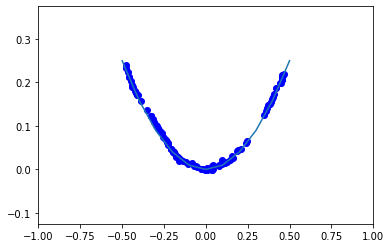

In [26]:
train(generator_model, model, gan_model, 5, n_epochs = 20000)
summarize_performance(generator_model, 5)

Получилось! Если не получилось, то запусти обучение еще раз и сеть дообучится. Наконец посмотрим процесс обучения по шагам. Для этого сделаем функцию вывода

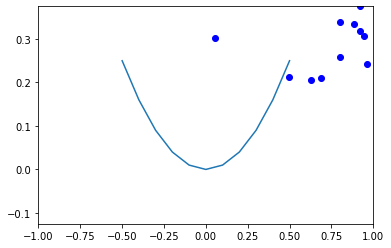

In [16]:
from PIL import Image
import imageio

gan_model.load_weights("output.gan_initial.h5")
images = []
epochs_total = 20000
frames = 100
for i in range (1, frames):
    train(generator_model, model, gan_model, 5, n_epochs = int(epochs_total / frames))
    summarize_performance(generator_model, 5, savename = "output.tmp.png")
    plt.cla()
    image = Image.open("output.tmp.png")
    ar = np.asarray(image)
    images.append(ar)
kargs = { 'duration': 0.1 }
imageio.mimsave('output.gan_learning.gif', images, None, **kargs)
summarize_performance(generator_model, 5)

Выходные файлы с GIF анимацией находятся в папке output. Далее можно поэкспериментировать с настроечными параметрами обоих сетей, размерностью латентного пространства, методом обучения и т.д.